<a href="https://colab.research.google.com/github/oughtinc/ergo/blob/notebooks-readme/notebooks/covid-19-inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes

* Switch to Italy
* Graph data and results
* Add variable for true initial infections, lockdown start date (11 March)
* Add lag time (see Jacob/NYT models)
* Add patient recovery

# Setup

Install [Ergo](https://github.com/oughtinc/ergo) (our forecasting library) and a few tools we'll use in this colab:

In [0]:
!pip install --quiet poetry  # Fixes https://github.com/python-poetry/poetry/issues/532
!pip install --quiet pendulum seaborn
!pip install --quiet torchviz

In [0]:
# !pip uninstall --yes --quiet ergo
!pip install  --quiet git+https://github.com/oughtinc/ergo.git@william
# !pip install --upgrade --no-cache-dir --quiet git+https://github.com/oughtinc/ergo.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [0]:
import ergo

confirmed_infections = ergo.data.covid19.ConfirmedInfections()

In [0]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [0]:
import re
import ergo
import pendulum
import pandas
import seaborn

from types import SimpleNamespace
from typing import List
from pendulum import DateTime
from matplotlib import pyplot

# Questions

Here are Metaculus ids for the questions we'll load, and some short names that will allow us to associate questions with variables in our model:

In [0]:
question_ids = [3704, 3712, 3713, 3711, 3722, 3761, 3705, 3706]  # 3740, 3736, 
question_names = [
  # "WHO Eastern Mediterranean Region on 2020/03/27",
  # "WHO Region of the Americas on 2020/03/27",
  # "WHO Western Pacific Region on 2020/03/27",
  # "WHO South-East Asia Region on 2020/03/27",
  "South Korea on 2020/03/27",
  # "United Kingdom on 2020/03/27",
  # "WHO African Region on 2020/03/27",
  # "WHO European Region on 2020/03/27",
  # "Bay Area on 2020/04/01",
  # "San Francisco on 2020/04/01"
]

We load the question data from Metaculus:

In [0]:
metaculus = ergo.Metaculus(username="ought", password="")
questions = [metaculus.get_question(id, name=name) for id, name in zip(question_ids, question_names)]
ergo.MetaculusQuestion.to_dataframe(questions)

,id,name,title,resolve_time
0,3704,South Korea on 2020/03/27,How many total confirmed cases of novel corona...,2020-03-27 09:00:00+00:00


# Data

Our most important data is the data about confirmed cases (from Hopkins):

In [0]:
confirmed_infections = ergo.data.covid19.ConfirmedInfections()

# Assumptions

Assumptions are things that should be inferred from data but currently aren't:

In [0]:
assumptions = SimpleNamespace()

In [0]:
assumptions.lockdown_start = {
  "Italy": pendulum.datetime(2020,3,11),
  "Spain": pendulum.datetime(2020,3,15),
}

# Model

Main model:

In [0]:
import torch
import pyro

Area = str

@ergo.model
def model(start: DateTime, end: DateTime, areas: List[Area], training=True):
  for area in areas:
    doubling_time = ergo.lognormal_from_interval(1., 14., name=f"doubling_time {area}")
    doubling_time_lockdown = ergo.lognormal_from_interval(1., torch.max(doubling_time, ergo.to_float(1.1)), name=f"doubling_time_lockdown {area}")
    observation_noise = ergo.halfnormal_from_interval(0.1, name=f"observation_noise {area}")
    predicted = ergo.to_float(confirmed_infections(area, start))

    for i in range(1,(end - start).days):
      date = start.add(days=i)
      datestr = date.format('YYYY/MM/DD')
      confirmed = None
      try:
        confirmed = ergo.to_float(confirmed_infections(area, date))
        ergo.tag(confirmed, f"actual {area} on {datestr}")
      except KeyError:
        pass
      doubling_time_today = doubling_time
      if area in assumptions.lockdown_start.keys() and date >= assumptions.lockdown_start[area]:
        doubling_time_today = doubling_time_lockdown
      predicted = predicted * 2**(1. / doubling_time_today)
      ergo.tag(predicted, f"predicted {area} on {datestr}")
      if (not training) or (confirmed is not None):
        predict_observed = ergo.normal(predicted, 
                                      predicted*observation_noise, 
                                      name=f"predict_observed {area} on {datestr}",
                                      obs=confirmed)

Run the model:

In [0]:
start_date = pendulum.datetime(2020,3,1)
end_date = pendulum.datetime(2020,4,1)
areas = ["Italy", "Spain"]
model_args = (start_date, end_date, areas)


In [0]:
import pandas as pd
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
import functools

def infer_and_run(model, num_samples=5000, num_iterations=2000, 
                  debug=False, learning_rate=0.01, 
                  early_stopping_patience=200) -> pd.DataFrame:
  """
    debug - whether to output debug information
    num_iterations - Number of optimizer iterations
    learning_rate - Optimizer learning rate
    early_stopping_patience - Stop training if loss hasn't improved for this many iterations
  """
  def to_numpy(d):
    return {k:v.detach().numpy() for k, v in d.items()}

  def debug_output(guide):
    quantiles = to_numpy(guide.quantiles([0.05, 0.5, 0.95]))
    for k, v in quantiles.items():
      print(f"{k}: {v[1]:.4f} [{v[0]:.4f}, {v[2]:.4f}]")

  guide = pyro.infer.autoguide.AutoNormal(model, 
                                          init_loc_fn=pyro.infer.autoguide.init_to_median)
  pyro.clear_param_store()
  guide(training=True)
  adam = pyro.optim.Adam({"lr": 0.01})
  svi = SVI(model, guide, adam, loss=Trace_ELBO())

  if debug:
    debug_output(guide)
    print()

  best_loss = None
  last_improvement = None

  for j in range(num_iterations):
      # calculate the loss and take a gradient step
      loss = svi.step(training=True)
      if best_loss is None or best_loss > loss:
        best_loss = loss
        last_improvement = j
      if j % 100 == 0:
        if debug:
          print("[iteration %04d]" % (j + 1 ))
          print(f"loss: {loss:.4f}")
          debug_output(guide)
          print()
        if j > (last_improvement + early_stopping_patience):
          print("Stopping Early")
          break

  print(f"Final loss: {loss:.4f}")
  predictive = Predictive(model, guide=guide, num_samples=num_samples)
  raw_samples = predictive(training=False)
  return pandas.DataFrame(to_numpy(raw_samples))



samples = infer_and_run(functools.partial(model, *model_args),
                        num_iterations=1000, 
                        num_samples=1000,
                        debug=True)
samples.describe().transpose()

ERROR! Session/line number was not unique in database. History logging moved to new session 63
doubling_time Italy: 5.3190 [4.5122, 6.2699]
doubling_time_lockdown Italy: 2.2932 [1.9454, 2.7031]
observation_noise Italy: 0.0391 [0.0332, 0.0461]
doubling_time Spain: 4.0816 [3.4625, 4.8113]
doubling_time_lockdown Spain: 1.8753 [1.5908, 2.2105]
observation_noise Spain: 0.0400 [0.0339, 0.0471]

[iteration 0001]
loss: 84950.2814
doubling_time Italy: 5.2660 [4.4747, 6.1974]
doubling_time_lockdown Italy: 2.3162 [1.9681, 2.7258]
observation_noise Italy: 0.0395 [0.0335, 0.0466]
doubling_time Spain: 4.0410 [3.4224, 4.7713]
doubling_time_lockdown Spain: 1.8566 [1.5776, 2.1850]
observation_noise Spain: 0.0404 [0.0342, 0.0477]

[iteration 0101]
loss: 1774.4991
doubling_time Italy: 3.7038 [3.3161, 4.1367]
doubling_time_lockdown Italy: 4.2917 [3.7622, 4.8958]
observation_noise Italy: 0.0646 [0.0551, 0.0756]
doubling_time Spain: 2.6136 [2.2543, 3.0303]
doubling_time_lockdown Spain: 1.4730 [1.2735, 1.703

,count,mean,std,min,25%,50%,75%,max
doubling_time Italy,1000.0,3.232849,0.074797,3.005837,3.180853,3.231117,3.281363,3.569232e+00
doubling_time_lockdown Italy,1000.0,5.255781,0.166990,4.755096,5.142208,5.246454,5.364786,5.850306e+00
observation_noise Italy,1000.0,0.091576,0.008699,0.068875,0.085420,0.090952,0.097308,1.265293e-01
predict_observed Italy on 2020/03/28,1000.0,125781.632812,16179.833984,78046.007812,115215.675781,125122.894531,135135.671875,1.880543e+05
predict_observed Italy on 2020/03/29,1000.0,144580.375000,18696.285156,81206.281250,131607.417969,143576.250000,156668.558594,2.255855e+05
...,...,...,...,...,...,...,...,...
predict_observed Spain on 2020/03/27,1000.0,65719.742188,0.742559,65719.000000,65719.000000,65719.000000,65719.000000,6.571900e+04
predicted Spain on 2020/03/28,1000.0,178202.906250,77222.695312,56154.687500,126340.050781,161199.429688,211736.882812,6.055816e+05
predicted Spain on 2020/03/29,1000.0,228966.140625,103846.812500,68026.437500,158670.394531,205964.226562,271373.148438,8.109064e+05
predicted Spain on 2020/03/30,1000.0,294328.687500,139674.203125,82408.015625,199308.460938,263254.609375,350478.812500,1.103294e+06


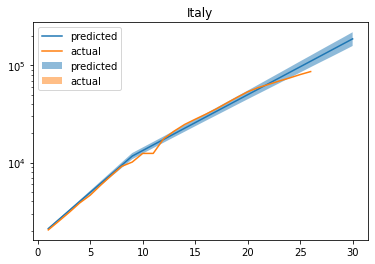

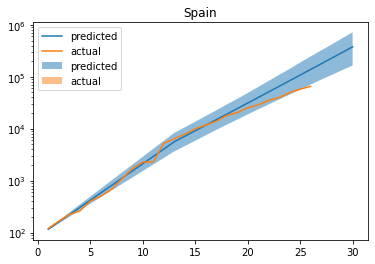

In [0]:
from datetime import datetime

to_plot = [
  # ("predict_observed", "predict_observed {area} on {date}"),
  ("predicted", "predicted {area} on {date}"),
  ("actual", "actual {area} on {date}"), 
]

high_quantile = 0.95
low_quantile = 0.05

for area in areas:
  for name, template in to_plot:    
    indices = [x for x in range((end_date - start_date).days)]
    highs = []
    lows = []
    means = []
    for i in indices:
      date = start_date.add(days=i)
      datestr = date.format('YYYY/MM/DD')
      key = template.format(area = area, date=datestr)
      try:
        means.append(samples[key].mean())
        highs.append(samples[key].quantile(high_quantile))
        lows.append(samples[key].quantile(low_quantile))
      except KeyError:
        means.append(float("NaN"))
        highs.append(float("NaN"))
        lows.append(float("NaN"))
    pyplot.fill_between(indices, lows, highs, label=name, alpha=0.5)
    pyplot.plot(indices, means, label=name)
  pyplot.title(area)
  pyplot.legend()
  pyplot.yscale("log")
  pyplot.show()